**Autor: Mariana Chaves**
 
**Date: August 2022**

In this notebook we train [BERT](https://arxiv.org/abs/1810.04805) models to classify movie characters according to their gender based on their dialogues. 
That is, each sample contains all utterances on the character.
We use pre-trained BERT models and fine-tuned them for our specific task. 
Specifically, we employed the BERT model pre-trained on [English Wikipedia and BooksCorpus datasets](https://tfhub.dev/google/collections/experts/bert/1).
Among the pre-trained models available at Tesorflow Hub, I deemed this to be the one with a pre-training closest to our eventual fine-tuning on the preprocessed Cornell corpus dataset.

Two BERT models were fine-tuned.
One used as input the original text and the other the altered version of the dialogues where punctuation and words that appear less than 5 times were removed.
The weights of the final model are obtained by rewinding them to the values that achieved the lowest validation loss.
First we show the models trained using classic train, validation, test splitting. 
Subsequenly, we show the models trained using **leave-some-movies-out** (At each fold, some group of movies are used as testing set).  

# Setup

Install the following if you don't have them already

In [ ]:
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 8.2 MB/s 


In [ ]:
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 51.5 MB/s 
     |████████████████████████████████| 99 kB 11.6 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 1.2 MB 57.1 MB/s 
     |████████████████████████████████| 596 kB 63.1 MB/s 
     |████████████████████████████████| 352 kB 76.8 MB/s 
     |████████████████████████████████| 238 kB 53.6 MB/s 
     |████████████████████████████████| 116 kB 56.2 MB/s 


In [ ]:
!pip install scikit-learn-extra

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 9.0 MB/s 


In [1]:
import os
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import time
import pickle
import myfunctions 
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

c:\Users\Dell\AppData\Local\Programs\Python\Python38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%cd ..

c:\Users\Dell\Documents\UCA DSAI\Internship 2\Code\text-models


# Functions

Here we show the functions used for training in a compact way. 
For more detail explanaitions see the notebook ```BERT_explained.ipynb```. 

In [3]:
# Information required according to each BERT model
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}


In [ ]:
def to_tensorflow_dataset(X, y):
  '''
  Transforms a list of texts X and a binary variable y into a tensorflow dataset with variables called 'text' and 'label' 
  '''

  df = pd.DataFrame({'text': X, 'label': y})
  tf_ds = tf.data.Dataset.from_tensor_slices(
          (
              tf.cast(df['text'].values, tf.string),
              tf.cast(df['label'].values, tf.int32)
          )
      )
  return tf_ds.shuffle(5000).batch(32)

In [ ]:
def train_BERT(x_train, x_val, x_test, y_train, y_val, y_test, 
               bert_model_name, 
               path_to_models, 
               model_name_suffix, 
               epochs,
               save_results_to_pickle = True,
               return_results = False,
               verbose = 1):
    '''
    Trains a BERT model. 
    Inputs: 
        x_train, x_val, x_test: text lists of each dataset (train, validation test)
        y_train, y_val, y_test: target variable lists of each dataset
        bert_model_name: name of the pretained BERT model. Check the possible names using map_name_to_handle.keys() 
        path_to_models: path to directory to save the model
        model_name_suffix: text to add to the name of the model 
        epochs: number of epochs
        save_results_to_pickle: If true, saves de results to a pickle file
        return_results: If true, returns the results
    '''

    # --------------------------
    # Data preparation
    # --------------------------

    # Test data by category
    x_test_1 = x_test[y_test == 1] 
    x_test_0 = x_test[y_test == 0]
    y_test_1 = y_test[y_test == 1] 
    y_test_0 = y_test[y_test == 0]

    # Transform to tf.data.Dataset
    train_ds = to_tensorflow_dataset(x_train, y_train)
    val_ds = to_tensorflow_dataset(x_val, y_val)
    test_ds = to_tensorflow_dataset(x_test, y_test)
    test_ds1 = to_tensorflow_dataset(x_test_1, y_test_1)
    test_ds0 = to_tensorflow_dataset(x_test_0, y_test_0)

    # --------------------------
    # BERT model
    # --------------------------

    # Choose a BERT model to fine-tune and its proper pre-processing
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

    # Preprocessing model
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    # BERT model
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    classifier_model = build_classifier_model()

    # Loss and evaluation metrics
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # Callbacks
    mc = tf.keras.callbacks.ModelCheckpoint(path_to_models + bert_model_name + model_name_suffix + '.h5', monitor='val_loss', mode='min', save_best_only=True, verbose = 0)

    # Hyperparameters
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    init_lr = 3e-5

    # Optimizer
    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    # Compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)


    # --------------------------
    # Train
    # --------------------------
    start_time = time.time()
    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x = train_ds,
                                  validation_data = val_ds,
                                  epochs = epochs,
                                  callbacks = [mc], 
                                   verbose = verbose)
    execution_time = (time.time() - start_time) / 60

    # --------------------------
    # Evaluation
    # --------------------------
    # Load saved models
    saved_model = tf.keras.models.load_model(path_to_models + bert_model_name + model_name_suffix + '.h5', custom_objects={'KerasLayer':hub.KerasLayer, 'AdamWeightDecay': optimizer})

    # Evaluate in train and test set
    train_loss, train_accuracy = saved_model.evaluate(train_ds)
    test_loss, test_accuracy = saved_model.evaluate(test_ds)
    # Accuracy by label
    test_loss1, test_accuracy1 = saved_model.evaluate(test_ds1)
    test_loss0, test_accuracy0 = saved_model.evaluate(test_ds0)

    # # Get predictions for test (something is off, check later if possible)
    # test_preds = saved_model.predict(test_ds)
    # # To integers
    # test_preds = np.array([i[0] for i in (test_preds > 0)]).astype(int)
    # print(f'Test accuracy: {test_accuracy}')

    # --------------------------
    # Save results
    # --------------------------
    results = {'history_metrics': history.history, 
              'train_accuracy': train_accuracy, 
              'test_accuracy': test_accuracy, 
              'test_accuracy_1': test_accuracy1,
              'test_accuracy_0': test_accuracy0,
              'execution_time': execution_time,
              }
    if save_results_to_pickle: 
        pickle.dump(results, open( path_to_models + bert_model_name + model_name_suffix + ".pickle", "wb" ))
    if return_results:
        return results


In [ ]:
def leave_one_group_out_BERT(data, group_variable, text_variable, target_variable, bert_model_name, path_to_models, model_name_suffix, epochs):
    '''
    Performs leave-one-group-out cross-validation on BERT tensorflow models. 
    Leave-one-group-out is similar to leave-one-out with the difference that instead of leaving just one sample out each time, all samples belonging to a group are lefted out, and the work as test set.  
    The dataset should be provided as a pandas dataframe. 
    The dataset must contain a text variable, a binary target variable and a variable that indicates the groups for using leave-one-group-out. 

    Requiered arguments: 
        data: pandas dataframe. 
        group_variable: the name of the variable that contains the groups (for the leave-one-out)
        text_variable: the name of the variable that contains the text.
        target_variable: the name of the variable that contains the target variable (binary variable).
        path_to_models: path to directory to save the model
        model_name_suffix: text to add to the name of the model 
        epochs: number of epochs
    '''

    # Groups for leave-one-group-out
    groups = np.unique(data[group_variable])

    # Empty dictionary to store results
    results = {'history_metrics': [], 'train_accuracy': [], 'test_accuracy': [], 'test_accuracy_1': [], 'test_accuracy_0': [], 'execution_time': [] }

    # For each group
    for group in groups:
        #-----------------------------
        # Split train val test
        #-----------------------------

        train_data = data[data[group_variable] != group]
        test_data = data[data[group_variable] == group]

        x = train_data[text_variable]
        y = train_data[target_variable]
        x_test = test_data[text_variable]
        y_test = test_data[target_variable]
        x_train, x_val, y_train, y_val  = myfunctions.balanced_split_train_val_test(x, y, train_split = 0.8, val_split = 0, test_split = 0.2, random_seed = 32)

        # --------------------------
        # Train model
        # --------------------------
        results_group = train_BERT(x_train, x_val, x_test, y_train, y_val, y_test, 
                                  bert_model_name, 
                                  path_to_models, 
                                  model_name_suffix = model_name_suffix + str(group), 
                                  epochs = epochs, 
                                  save_results_to_pickle = False, 
                                  return_results = True,
                                  verbose = 0)
        
        # --------------------------
        # Save results
        # --------------------------
        results['history_metrics'].append(results_group['history_metrics'])
        results['train_accuracy'].append(results_group['train_accuracy'])
        results['test_accuracy'].append(results_group['test_accuracy'])
        results['test_accuracy_1'].append(results_group['test_accuracy_1'])
        results['test_accuracy_0'].append(results_group['test_accuracy_0'])
        results['execution_time'].append(results_group['execution_time'])

        print('----------------------------')
        print('Finished for group:', group)
        print('----------------------------')

    pickle.dump(results, open( path_to_models + bert_model_name + model_name_suffix + 'LOGO' + ".pickle", "wb" ))

# Load data

In [ ]:
# Load data
cornell_prepro_characters = pd.read_csv('datasets/cornell_corpus/cornell_prepro_characters.csv')

# Keep only the words that appeared 5 times or more times
vocab = myfunctions.get_ngram_vocab(text = cornell_prepro_characters['text'], ngram_range = (1,1), minimum_occurrences = 5)
cornell_prepro_characters['text_chosen_vocab'] = myfunctions.keep_only_words_in_vocabulary(text = cornell_prepro_characters['text'], vocabulary = vocab, lower = True)

# Binary target variable
cornell_prepro_characters['target'] = np.array(cornell_prepro_characters['gender'] == 'F').astype(int)
cornell_prepro_characters

ngrams that show up 5 or more times: 11233


,Unnamed: 0,characterID,movieID,character_name,gender,movie_title,movie_year,movieGroup,text_with_punctuation,text,text_chosen_vocab,target
0,0,u0,m0,BIANCA,F,10 things i hate about you,1999,1,They do not! I hope so. Let's go. Okay you're ...,They do not I hope so Lets go Okay youre gonna...,they do not hope so lets go okay youre gonna n...,1
1,1,u100,m6,AMY,F,8mm,1999,1,She died in her sleep three days ago. It was i...,She died in her sleep three days ago It was in...,she died in her sleep three days ago it was in...,1
2,2,u1001,m65,PETE,M,from dusk till dawn,1996,5,Six-fifty. Knock yourself out. That's all that...,Sixfifty Knock yourself out Thats all thats be...,knock yourself out thats all thats been on the...,0
3,3,u1007,m66,BLONDELL,F,g.i. jane,1997,1,Wow Uh don't see it. There's no signature. But...,Wow Uh dont see it Theres no signature But han...,wow uh dont see it theres no signature but han...,1
4,4,u1008,m66,C.O.,M,g.i. jane,1997,1,"Of course, but there's more Uh, V.I.P. securit...",Of course but theres more Uh VIP security arra...,of course but theres more uh security arrangem...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2399,2399,u983,m64,ALICE,F,friday the 13th,2009,3,Maybe we should wait for Mr. Christy. The kill...,Maybe we should wait for Mr Christy The killer...,maybe we should wait for mr christy the killer...,1
2400,2400,u985,m64,BILL,M,friday the 13th,2009,3,It's over twenty miles to the crossroads. Stev...,Its over twenty miles to the crossroads Stevel...,its over twenty miles to the be back in an hou...,0
2401,2401,u989,m64,MARCIE,F,friday the 13th,2009,3,Gotta pee. You're lying on my bladder. Like wa...,Gotta pee Youre lying on my bladder Like waves...,gotta pee youre lying on my like waves its nev...,1
2402,2402,u993,m64,STEVE,M,friday the 13th,2009,3,I've got to go to town and pick up the trailer...,Ive got to go to town and pick up the trailer ...,ive got to go to town and pick up the trailer ...,0


# Train BERT models

Using dataset with modified text: 
Only words that appear more than 5 times are taken into consideration. Punctuation is removed and all tokens are in lower case. 

In [ ]:
# Split data
x_train, x_val, x_test, y_train, y_val, y_test = myfunctions.balanced_split_train_val_test(X = cornell_prepro_characters['text_chosen_vocab'], 
                                                                                           y = cornell_prepro_characters['target'], 
                                                                                           train_split = 0.7, val_split = 0.2, test_split = 0.1, 
                                                                                           random_seed = 32)
# Train BERT model and save results 
train_BERT(x_train, x_val, x_test, y_train, y_val, y_test, 
           bert_model_name = 'experts_wiki_books', 
           path_to_models = 'results/models/', 
           model_name_suffix = 'BERT_modified_text', 
           epochs = 20)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
Epoch 1/20
53/53 [==============================] - 59s 783ms/step - loss: 0.7449 - binary_accuracy: 0.5131 - val_loss: 0.7141 - val_binary_accuracy: 0.4990
Epoch 2/20
53/53 [==============================] - 35s 669ms/step - loss: 0.7316 - binary_accuracy: 0.5208 - val_loss: 0.7251 - val_binary_accuracy: 0.5593
Epoch 3/20
53/53 [==============================] - 48s 920ms/step - loss: 0.7460 - binary_accuracy: 0.5030 - val_loss: 0.6950 - val_binary_accuracy: 0.5010
Epoch 4/20
53/53 [==============================] - 35s 652ms/step - loss: 0.7285 - binary_accuracy: 0.5125 - val_loss: 0.8088 - val_binary_accuracy: 0.5010
Epoch 5/20
53/53 [==============================] - 47s 884ms/step - loss: 0.7259 - binary_accuracy: 0.5398 - val_loss: 0.6710 - val_binary_accuracy: 0.5010
Epoch 6/20
53/53 [==============================] - 48s 916ms/step - loss: 0.6540 - binary_accuracy: 0.5975 - val_loss: 0.6363 - val_binary_accu

Using dataset with original text: 

In [ ]:
# Split data
x_train, x_val, x_test, y_train, y_val, y_test = myfunctions.balanced_split_train_val_test(X = cornell_prepro_characters['text_with_punctuation'], 
                                                                                           y = cornell_prepro_characters['target'], 
                                                                                           train_split = 0.7, val_split = 0.2, test_split = 0.1, 
                                                                                           random_seed = 32)
# Train BERT model and save results 
train_BERT(x_train, x_val, x_test, y_train, y_val, y_test, 
           bert_model_name = 'experts_wiki_books', 
           path_to_models = 'results/models/', 
           model_name_suffix = 'BERT_text_original_text', 
           epochs = 20)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
Epoch 1/20
53/53 [==============================] - 63s 795ms/step - loss: 0.7202 - binary_accuracy: 0.5232 - val_loss: 0.7036 - val_binary_accuracy: 0.5010
Epoch 2/20
53/53 [==============================] - 50s 949ms/step - loss: 0.6860 - binary_accuracy: 0.5499 - val_loss: 0.6298 - val_binary_accuracy: 0.6237
Epoch 3/20
53/53 [==============================] - 36s 686ms/step - loss: 0.6848 - binary_accuracy: 0.5791 - val_loss: 0.6643 - val_binary_accuracy: 0.6590
Epoch 4/20
53/53 [==============================] - 35s 666ms/step - loss: 0.6155 - binary_accuracy: 0.6611 - val_loss: 0.7703 - val_binary_accuracy: 0.6299
Epoch 5/20
53/53 [==============================] - 35s 667ms/step - loss: 0.5466 - binary_accuracy: 0.7176 - val_loss: 0.7211 - val_binary_accuracy: 0.6570
Epoch 6/20
53/53 [==============================] - 35s 666ms/step - loss: 0.4481 - binary_accuracy: 0.7907 - val_loss: 0.7537 - val_binary_accu

# Leave-some-movies-out

Leave-one-group-out cross-validation is used. In this case each group is a group of movies.  

In [ ]:
# On dataset with modified text
leave_one_group_out_BERT(data = cornell_prepro_characters, 
                         group_variable = 'movieGroup',
                         text_variable = 'text_chosen_vocab',
                         target_variable = 'target', 
                         bert_model_name = 'experts_wiki_books',
                         path_to_models = 'results/models/', 
                         model_name_suffix = 'BERT_modified_text', 
                         epochs = 20)
# On dataset with original text
leave_one_group_out_BERT(data = cornell_prepro_characters, 
                         group_variable = 'movieGroup',
                         text_variable = 'text_with_punctuation',
                         target_variable = 'target', 
                         bert_model_name = 'experts_wiki_books',
                         path_to_models = 'results/models/', 
                         model_name_suffix = 'BERT_text_original_text', 
                         epochs = 20)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
8/8 [==============================] - 2s 234ms/step - loss: 0.6695 - binary_accuracy: 0.9711
----------------------------
Finished for group: 1
----------------------------
Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
9/9 [==============================] - 2s 220ms/step - loss: 0.6331 - binary_accuracy: 0.9767
----------------------------
Finished for group: 2
----------------------------
Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
8/8 [==============================] - 2s 243ms/step - loss: 0.6825 - binary_accuracy: 0.8163
----------------------------
Finished for group: 3
----------------------------
Training model with https://tfhub.dev/google/experts/bert/wiki_books/2
8/8 [==============================] - 2s 224ms/step - loss: 0.5675 - binary_accuracy: 0.8363
----------------------------
Finished for group: 4
----------------------------
Training model with 

# Results

In [4]:
# Make sure to change this to your own path
path_of_saving_images = '//wsl$/Ubuntu-20.04/home/mchaves/internship2/final_report/internship_report/img/'

In [5]:
path_to_models = 'results/models/'
bert_model_name = 'experts_wiki_books'
model_name_suffixes = ['BERT_modified_text','BERT_text_original_text']
model_nice_name = ['BERT (using modified text)', 'BERT (using original text)']

## For models trained with classic train-validation-test split.

In [6]:
# Get results from individual models

table_of_results = {'Model': model_nice_name, 'Train accuracy':[], 'Test accuracy':[], 'Men accuracy (on test)':[], 'Women accuracy (on test)':[], 'Training time (minutes)': []}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Set': [], 'Metric': [], 'Values': []}

for model_name, model_name_suffix in zip(model_nice_name, model_name_suffixes): 

    # Load results
    results = pickle.load(open(path_to_models + bert_model_name + model_name_suffix + ".pickle", "rb" ))
    
    # Results for table   
    table_of_results['Train accuracy'].append(results['train_accuracy'] * 100)
    table_of_results['Test accuracy'].append(results['test_accuracy'] * 100)
    table_of_results['Men accuracy (on test)'].append(results['test_accuracy_0'] * 100)
    table_of_results['Women accuracy (on test)'].append(results['test_accuracy_1'] * 100)
    table_of_results['Training time (minutes)'].append(results['execution_time'])

    # Results for plot 
    metrics_history = results['history_metrics']   
    epochs = len(metrics_history['loss']) 
    df_for_metrics_chart['Model'].extend([model_name] * 4 * epochs)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * 4)
    df_for_metrics_chart['Set'].extend(list(['Train'] *  epochs + ['Validation'] * epochs) * 2)
    df_for_metrics_chart['Metric'].extend(['Loss'] * 2 * epochs + ['Accuracy'] * 2 * epochs)
    df_for_metrics_chart['Values'].extend(metrics_history['loss'] + metrics_history['val_loss'] + list(np.array(metrics_history['binary_accuracy']) * 100) + list(np.array(metrics_history['val_binary_accuracy']) * 100))
  
# To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)

# Latex table
print(table_of_results.to_latex(index=False))

# Show results
table_of_results



\begin{tabular}{lrrrrr}
\toprule
                     Model &  Train accuracy &  Test accuracy &  Men accuracy (on test) &  Women accuracy (on test) &  Training time (minutes) \\
\midrule
BERT (using modified text) &           73.54 &          65.56 &                   66.67 &                     64.46 &                    14.46 \\
BERT (using original text) &           64.68 &          64.32 &                   75.00 &                     53.72 &                    13.23 \\
\bottomrule
\end{tabular}



,Model,Train accuracy,Test accuracy,Men accuracy (on test),Women accuracy (on test),Training time (minutes)
0,BERT (using modified text),73.54,65.56,66.67,64.46,14.46
1,BERT (using original text),64.68,64.32,75.00,53.72,13.23


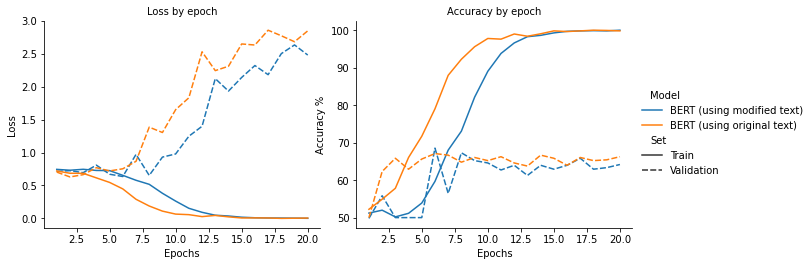

In [8]:
fig = sns.relplot(
    data = df_for_metrics_chart, kind = "line",
    x = "Epochs", y = "Values", col = "Metric",
    hue = "Model", style = "Set", 
    height=3.8, aspect = 1.2,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.set_titles('{col_name}' + ' by epoch' )
# fig.set_titles('')
for ax, title in zip(fig.axes.flat, ['Loss', 'Accuracy %']):
    ax.set_ylabel(title)
fig.savefig(path_of_saving_images + 'BERT_individual_model.png')
fig.savefig(path_of_saving_images + 'BERT_individual_model.pdf')

## For leave-one-group-out

In [9]:
table_of_results = {'Model': model_nice_name, 'Avg. train accuracy \u00B1 std':[], 'Avg. test accuracy \u00B1 std':[], 'Avg. men accuracy \u00B1 std (on test)':[], 'Avg. women accuracy \u00B1 std (on test)':[], 'Training time (minutes)': []}
df_for_metrics_chart = {'Model': [], 'Epochs': [], 'Set': [], 'Metric': [], 'Values': [], 'Group': []}

for model_name, model_name_suffix in zip(model_nice_name, model_name_suffixes): 

    # Load results
    results = pickle.load(open(path_to_models + bert_model_name + model_name_suffix + 'LOGO' + ".pickle", "rb" ))
    
    # Results for table
    results_keys = ['train_accuracy', 'test_accuracy', 'test_accuracy_0', 'test_accuracy_1']
    table_keys = ['Avg. train accuracy \u00B1 std', 'Avg. test accuracy \u00B1 std', 'Avg. men accuracy \u00B1 std (on test)', 'Avg. women accuracy \u00B1 std (on test)']
    for key, table_key in zip(results_keys, table_keys):
        mean_and_std = str(np.round(np.mean(results[key])*100, 2)) + ' \u00B1 ' +  str(np.round(np.std(results[key])*100, 2))
        table_of_results[table_key].append(mean_and_std)
    table_of_results['Training time (minutes)'].append(np.mean(results['execution_time']))

    # # Results for plot 
    metrics_history = results['history_metrics']   
    groups = len(metrics_history)
    epochs = len(metrics_history[0]['loss']) 
    df_for_metrics_chart['Model'].extend([model_name] * 4 * epochs * groups)
    df_for_metrics_chart['Epochs'].extend(list(range(1,epochs+1)) * 4 * groups)
    df_for_metrics_chart['Set'].extend(list(['Train'] *  epochs * groups + ['Validation'] * epochs * groups) * 2)
    df_for_metrics_chart['Metric'].extend(['Loss'] * 2 * epochs *groups + ['Accuracy'] * 2 * epochs * groups)
    df_for_metrics_chart['Group'].extend(list(np.repeat(range(1, groups + 1), epochs)) * 4)
    df_for_metrics_chart['Values'].extend(np.concatenate((
                                                        np.array([i['loss'] for i in metrics_history]).flatten(), 
                                                        np.array([i['val_loss'] for i in metrics_history]).flatten(),
                                                        np.array([i['binary_accuracy'] for i in metrics_history]).flatten() * 100,
                                                        np.array([i['val_binary_accuracy'] for i in metrics_history]).flatten() * 100
                                                        )))
  
# # To pandas dataframes
table_of_results = pd.DataFrame(table_of_results).round(2)
df_for_metrics_chart = pd.DataFrame(df_for_metrics_chart)

# # Latex table
print(table_of_results.to_latex(index=False))

# # Show results
table_of_results


\begin{tabular}{lllllr}
\toprule
                     Model & Avg. train accuracy ± std & Avg. test accuracy ± std & Avg. men accuracy ± std (on test) & Avg. women accuracy ± std (on test) &  Training time (minutes) \\
\midrule
BERT (using modified text) &               62.82 ± 8.8 &             59.02 ± 6.71 &                      89.93 ± 6.64 &                        28.1 ± 20.03 &                    13.77 \\
BERT (using original text) &               73.5 ± 5.12 &             65.17 ± 1.66 &                      81.15 ± 5.43 &                         49.18 ± 7.8 &                    13.07 \\
\bottomrule
\end{tabular}



,Model,Avg. train accuracy ± std,Avg. test accuracy ± std,Avg. men accuracy ± std (on test),Avg. women accuracy ± std (on test),Training time (minutes)
0,BERT (using modified text),62.82 ± 8.8,59.02 ± 6.71,89.93 ± 6.64,28.1 ± 20.03,13.77
1,BERT (using original text),73.5 ± 5.12,65.17 ± 1.66,81.15 ± 5.43,49.18 ± 7.8,13.07


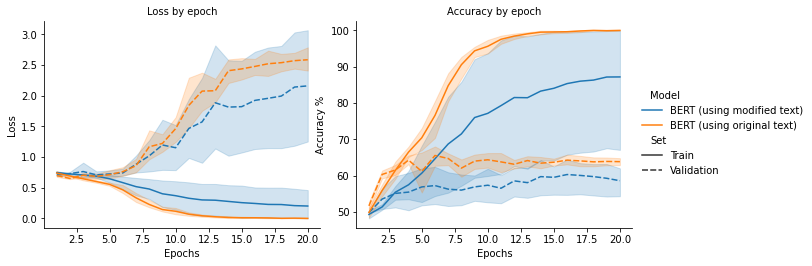

In [10]:
fig = sns.relplot(
    data = df_for_metrics_chart, kind = "line",
    x = "Epochs", y = "Values", col = "Metric",
    hue = "Model", style = "Set", 
    height=3.8, aspect = 1.2,
    facet_kws = dict(sharex = True, sharey=False)
)
fig.set_titles('{col_name}' + ' by epoch' )
# fig.set_titles('')
for ax, title in zip(fig.axes.flat, ['Loss', 'Accuracy %']):
    ax.set_ylabel(title)
fig.savefig(path_of_saving_images + 'BERT_LOGO.png')
fig.savefig(path_of_saving_images + 'BERT_LOGO.pdf')

The figure above depicts the progress of the training for both models, indicating signs of overfitting.
The second model (the one using the original text) shows considerably better test accuracy results, which was expected given that, compared to the altered text, the original one is more similar to the natural language on which the BERT model was pre-trained.
Moreover, using the modified text, the loss and accuracy present more variability.
Nevertheless, both models present poor accuracy for the category "female", which makes them untrustworthy.